 ## Dataset description
 All features are 60x60 RGB satellite images from various locations. Each image is classified as one or more types of land usage. A challenge when working with satellite images is the huge amount of data, combined with the complexity of processing natural images. Deep learning methods can handle such data. However, working with world-scale data introduces many edge-case and ambiguities, making uncertainty awareness a necessity.

Our training set consists 1800 satellite images, each corresponding to exactly one out of six types of land usage (see below for examples). However, the test set contains a certain fraction of images that correspond to multiple types of land usage, e.g., a body of water surrounded by a forest. Those mixed land usage types may include ones not present in the training set. Furthermore, some images might contain seasonal snow or clouds. The training and validation sets both include information about snowy and cloudy images (see train_dataset and validation_dataset in the main() method for details), but the test set does not. 

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import pearsonr

# feature design
from scipy.ndimage import convolve
from sklearn.cluster import KMeans
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.decomposition import PCA

# Set os.getwd + 1_gaussian_progress_regression to path
current_path = os.getcwd() # + '/2_BNN_satellite_img_classification'
sys.path.append(current_path)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# read and unpack the npz file from the current_path variable
X, y = np.load(current_path + '/train_xs.npz')["train_xs"].transpose(0, 2, 3, 1), np.load(current_path + '/train_ys.npz')["train_ys"]

X.shape, y.shape

((1800, 60, 60, 3), (1800,))

### 1. Basic Image Summary Statistics:

Check the resolution, pixel ranges, mean, and standard deviation across channels. Look for outliers or unexpected values.

Resolution: (60, 60, 3)
Pixel range: 0.0 to 1.0
Means per channel:
Class 0: [0.3589071  0.3147428  0.18020919] +/- [0.2072877  0.14814313 0.11276197]
Class 1: [0.1794168  0.30491027 0.12798703] +/- [0.11774421 0.16495812 0.07525019]
Class 2: [0.20008583 0.24212787 0.15955956] +/- [0.14957573 0.14892448 0.13548063]
Class 3: [0.2676776  0.3063239  0.42195565] +/- [0.27009922 0.26150826 0.31469414]
Class 4: [0.186976   0.27963424 0.11774124] +/- [0.13513878 0.11468286 0.07615686]
Class 5: [0.11979105 0.11761168 0.08496309] +/- [0.09310556 0.08298749 0.07490759]
Number of outliers or NA: 0


Text(0.5, 1.0, 'Label distribution')

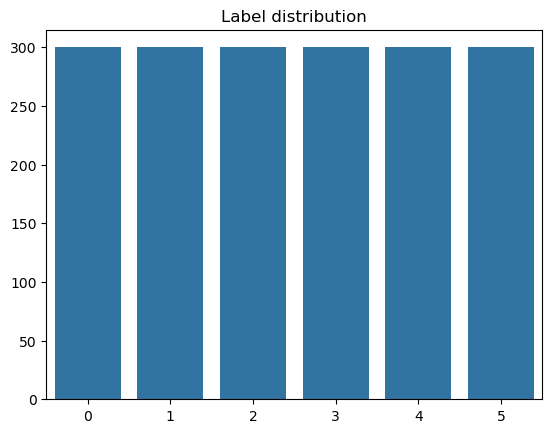

In [3]:
# Check the resolution
resolution = X.shape[1:4]
print(f"Resolution: {resolution}")

# Check pixel ranges
pixel_min = np.min(X)
pixel_max = np.max(X)
print(f"Pixel range: {pixel_min} to {pixel_max}")

# Calculate mean and standard deviation across channels
means_per_channel = [np.mean(X[y == y_i], axis=(0, 1, 2)) for y_i in np.unique(y)]
stds_per_channel = [np.std(X[y == y_i], axis=(0, 1, 2)) for y_i in np.unique(y)]
# print the means for every label
print("Means per channel:")
for i, (mean, std) in enumerate(zip(means_per_channel, stds_per_channel)):
    print(f"Class {i}: {mean} +/- {std}")

# Check for outliers or unexpected values
outliers = np.where((X < 0) | (X > 1) | np.isnan(X))
print(f"Number of outliers or NA: {len(outliers[0])}")

# Barplot the labels
unique_y, counts_y = np.unique(y, return_counts=True)
sns.barplot(x=unique_y, y=counts_y)
plt.title("Label distribution")

### 2. Channel-wise Analysis:

* Inspect the distribution of pixel intensities separately for the Red, Green, and Blue channels using histograms. This helps identify  color biases or overexposed/underexposed images.
* Calculate channel-wise correlations to see how the color channels are related.

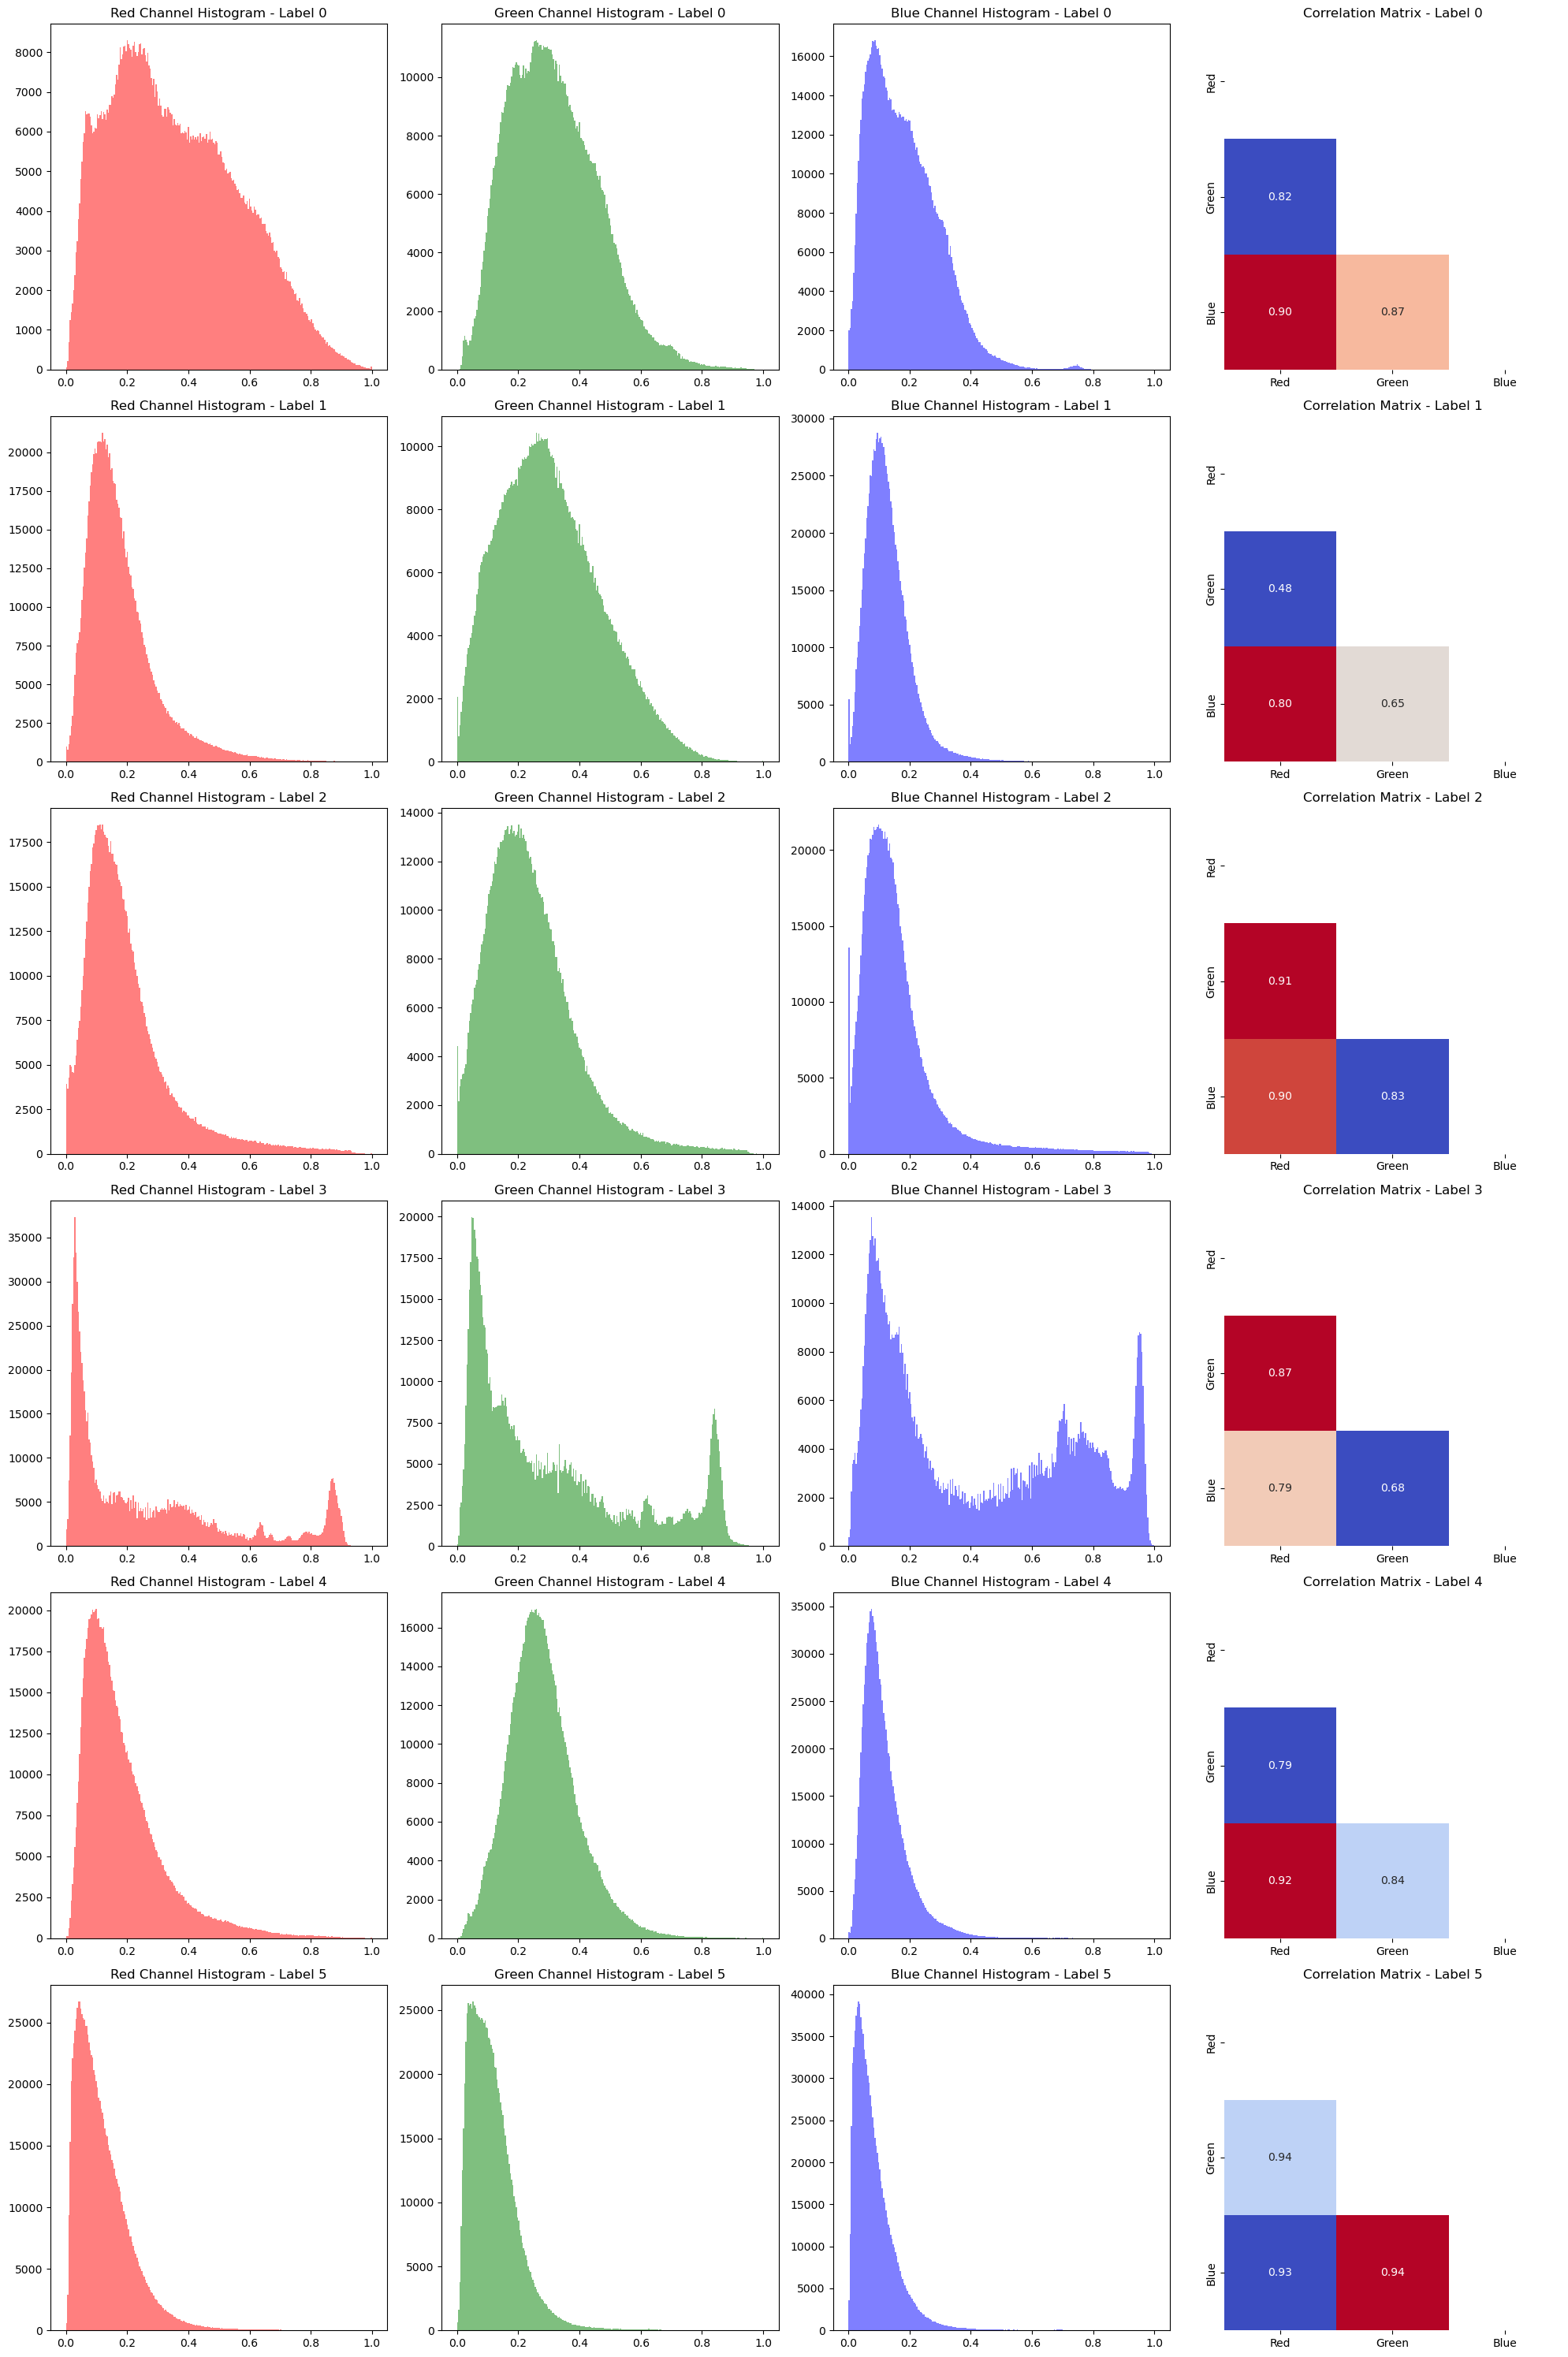

In [4]:
# Assuming y contains the labels for each image and X contains the image data

# If path current_path + '/channel_wise_dist.png' exist dont run the code
# if not os.path.exists(current_path + '/channel_wise_dist.png'):
labels = np.unique(y)

fig, axes = plt.subplots(len(labels), 4, figsize=(20, 30))

for i, label in enumerate(labels):
    label_indices = np.where(y == label)
    red_pixels = X[label_indices][:, :, :, 0].flatten()
    green_pixels = X[label_indices][:, :, :, 1].flatten()
    blue_pixels = X[label_indices][:, :, :, 2].flatten()

    # Plot histograms
    axes[i, 0].hist(red_pixels, bins=256, color='red', alpha=0.5)
    axes[i, 0].set_title(f'Red Channel Histogram - Label {label}')

    axes[i, 1].hist(green_pixels, bins=256, color='green', alpha=0.5)
    axes[i, 1].set_title(f'Green Channel Histogram - Label {label}')

    axes[i, 2].hist(blue_pixels, bins=256, color='blue', alpha=0.5)
    axes[i, 2].set_title(f'Blue Channel Histogram - Label {label}')

    # Calculate correlation matrix
    pixels = np.vstack((red_pixels, green_pixels, blue_pixels))
    correlation_matrix = np.corrcoef(pixels)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Plot correlation matrix as heatmap
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[i, 3], cbar=False,
                xticklabels=['Red', 'Green', 'Blue'], yticklabels=['Red', 'Green', 'Blue'], mask=mask)
    axes[i, 3].set_title(f'Correlation Matrix - Label {label}')

plt.tight_layout()
plt.show()

# # save the image to the current_path as channel_wise_dist.png
# plt.savefig(current_path + '/channel_wise_dist.png')

In [9]:
current_path

'c:\\Users\\paesc\\OneDrive\\docs\\projects\\probabilistic-artificial-intelligence-projects\\2_BNN_satellite_img_classification'

### 3. Spatial Patterns and Texture:

* Apply edge detection (e.g., Sobel, Canny) to reveal texture patterns or structural information.
* Use entropy maps to identify areas with high detail versus uniform regions.

In [5]:
def sobel_edge_detection(image):

    # Convert image to grayscale
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]) # Luminosity method

    # Sobel Kernels
    K_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    K_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    # Apply convolution in x and y directions
    G_x = convolve(image, K_x)
    G_y = convolve(image, K_y)
    
    # Calculate the gradient magnitude
    G = np.sqrt(G_x**2 + G_y**2)
    G = np.clip(G, 0, 255)  # Ensures pixel values remain valid
    
    return G

def calculate_entropy_map(image, kernel_size = 9): 

    # Convert image to grayscale, scale 0, 255 and convert data type to integer
    image = (np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]) * 255).astype(np.uint8)

    # Define the structuring element (disk) for entropy calculation
    footprint = disk(kernel_size // 2)
    
    # Calculate entropy using a local neighborhood defined by the footprint
    entropy_map = entropy(image, footprint)
    
    return entropy_map



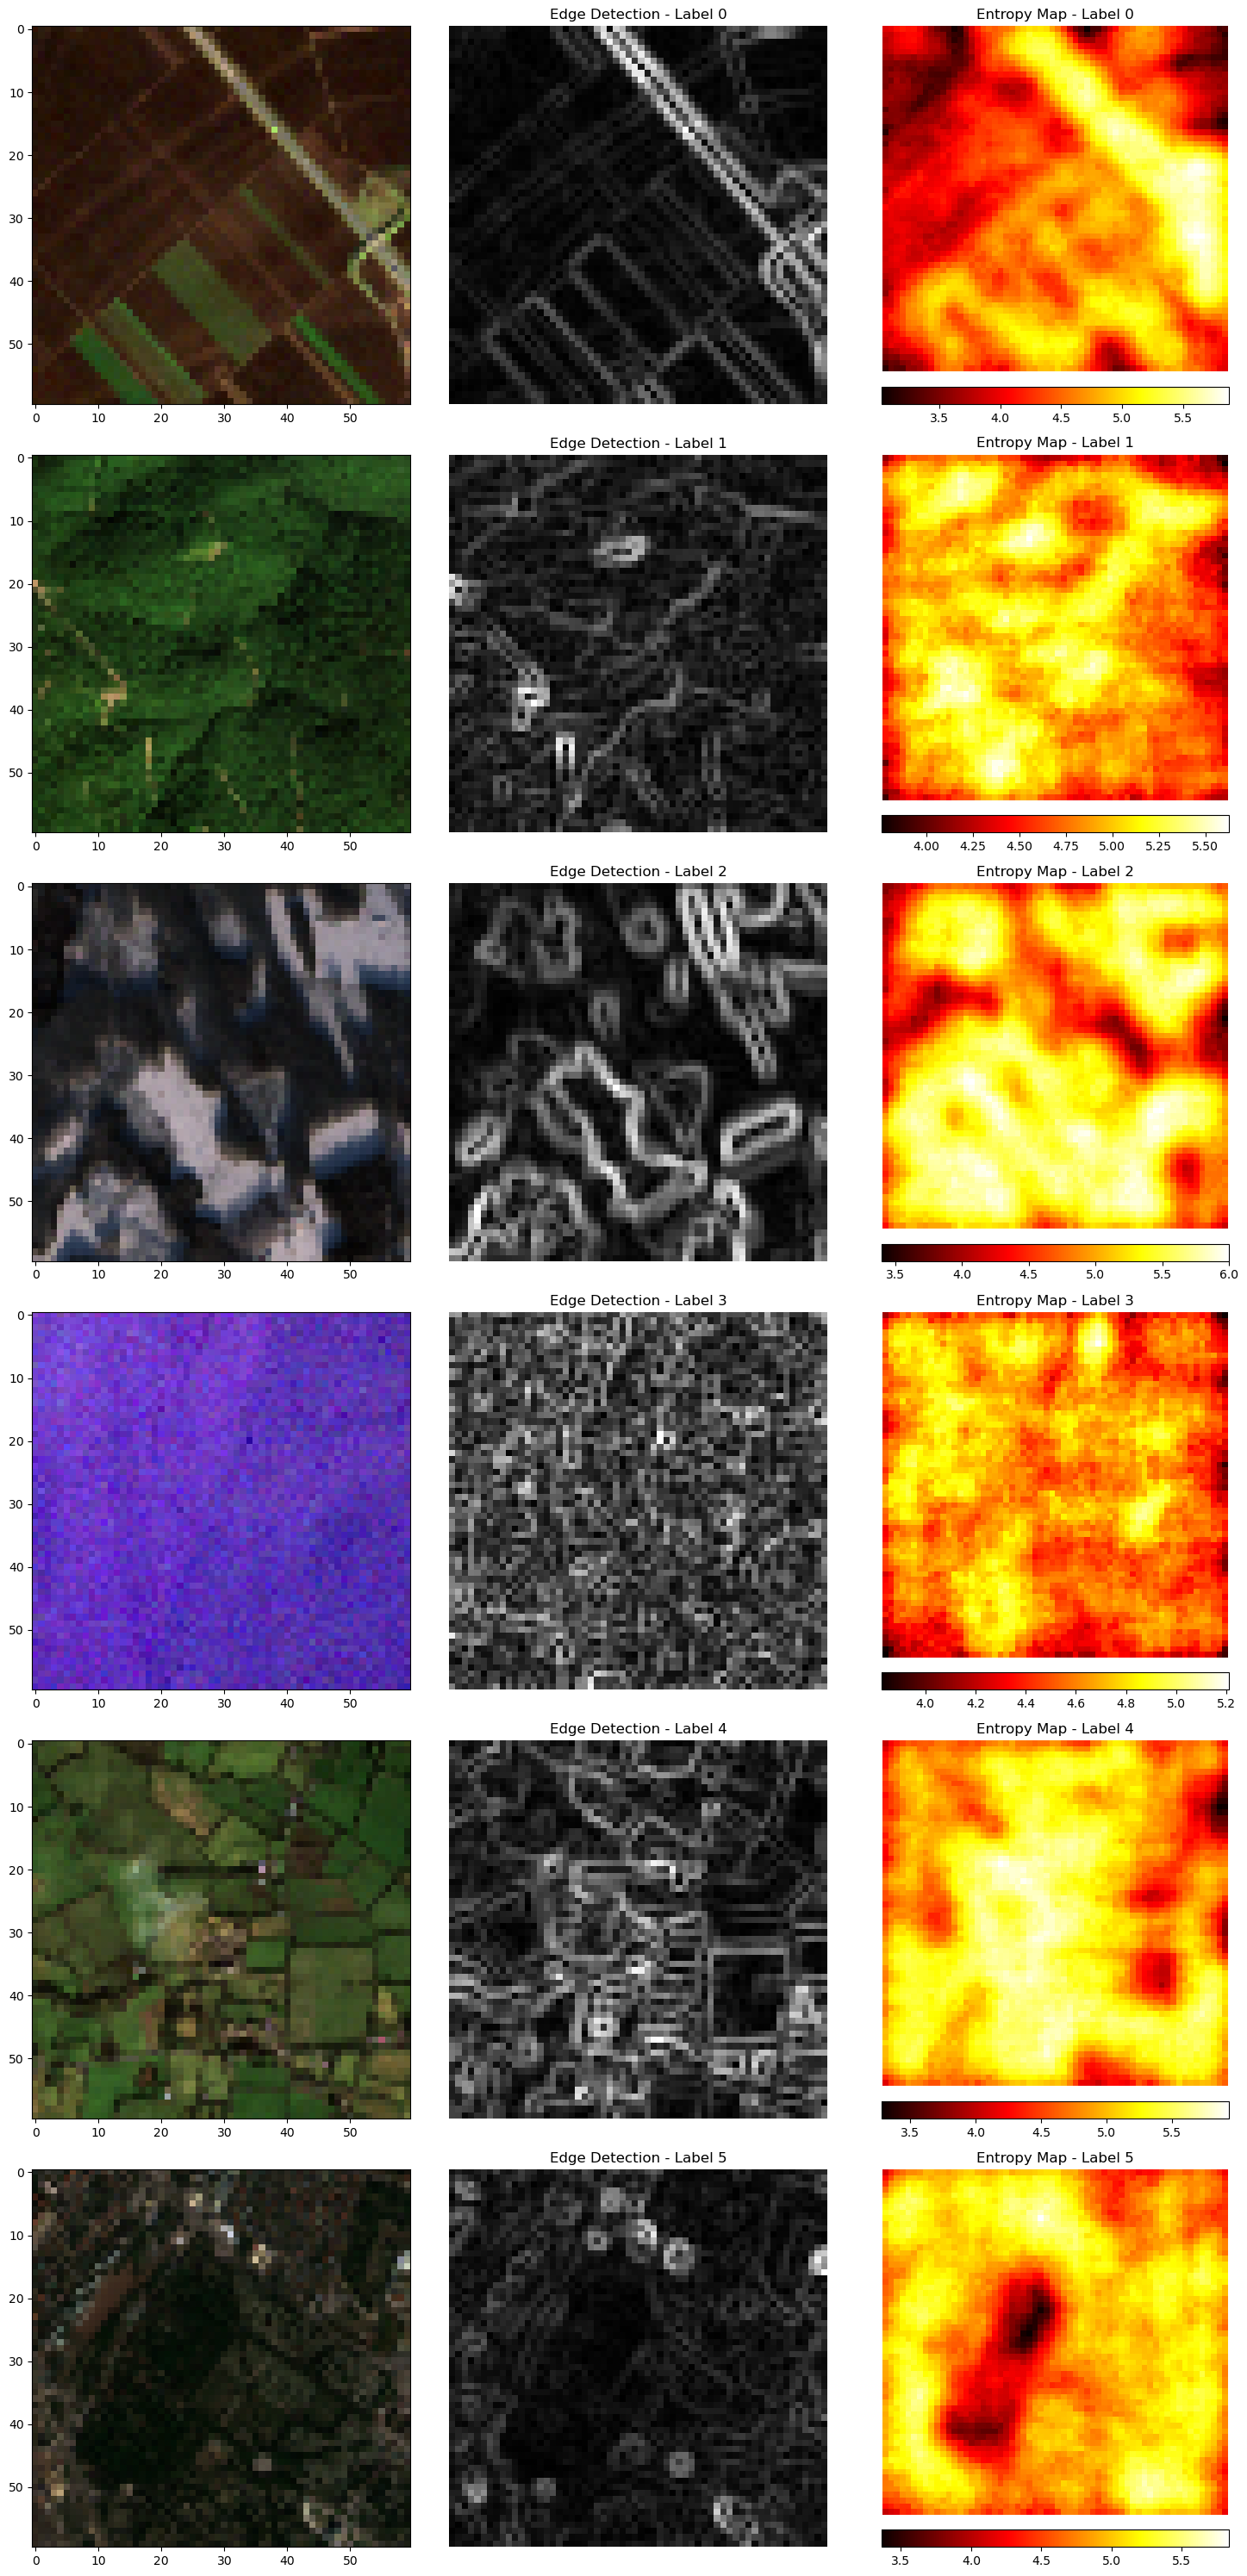

In [6]:
# Assuming y contains the labels for each image and X contains the image data
labels = np.unique(y)

# take a random integer from 0 to 299
random_index = np.random.randint(0, 300)

fig, axes = plt.subplots(len(labels), 3, figsize=(15, 30))

for i, label in enumerate(labels):
    label_indices = np.where(y == label)[0]
    image = X[label_indices[random_index]]  # Take the first image of the current label

    # Apply Sobel edge detection
    edge_image = sobel_edge_detection(image)

    # Apply entropy map calculation
    entropy_image = calculate_entropy_map(image, kernel_size=10)

    axes[i, 0].imshow(image)
    axes[i, 1].set_title(f'Original - Label {label}')
    axes[i, 1].axis('off')

    # Plot edge detection result
    axes[i, 1].imshow(edge_image, cmap='gray')
    axes[i, 1].set_title(f'Edge Detection - Label {label}')
    axes[i, 1].axis('off')

    # Plot entropy map result
    im = axes[i, 2].imshow(entropy_image, cmap='hot')
    axes[i, 2].set_title(f'Entropy Map - Label {label}')
    axes[i, 2].axis('off')

    # Add colorbar for entropy map
    fig.colorbar(im, ax=axes[i, 2], orientation='horizontal', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

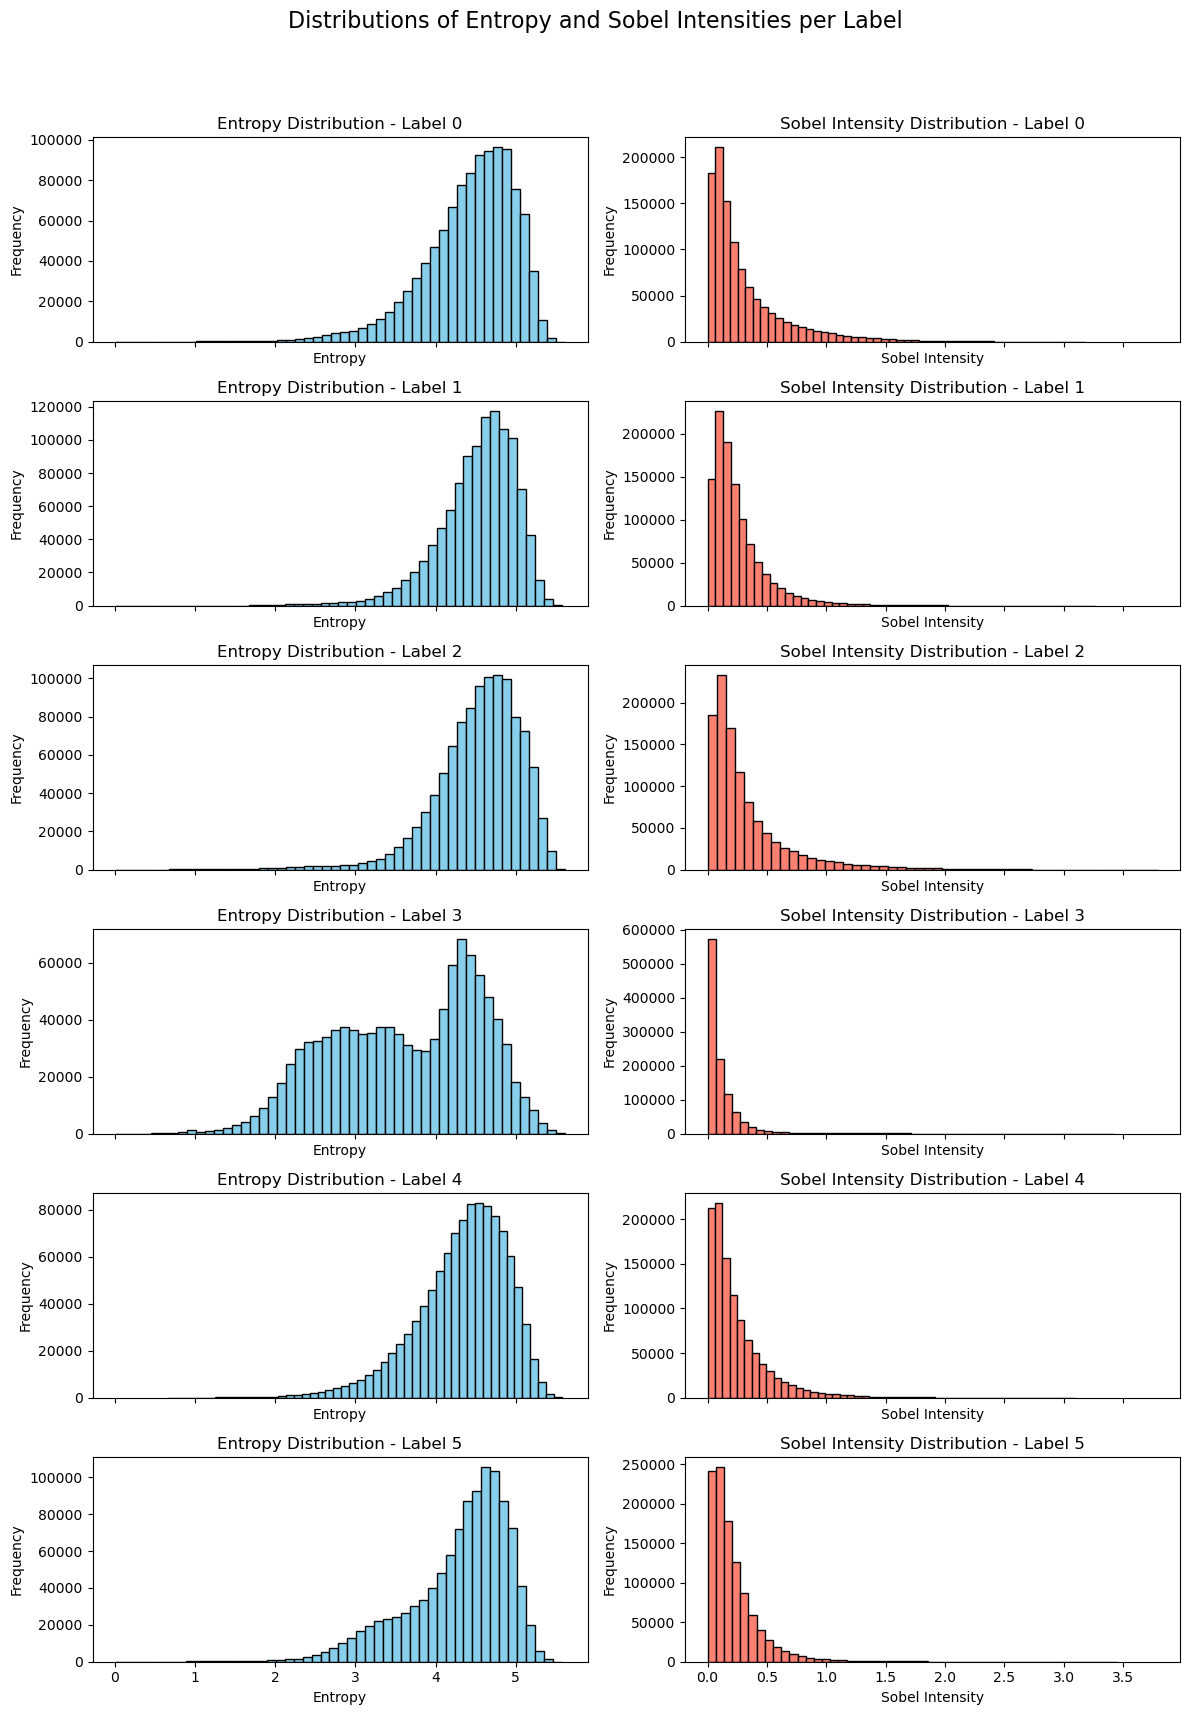

In [40]:
# Calculate entropy and Sobel intensities in one loop
num_images = X.shape[0]
entropy_by_label = [[] for _ in range(len(np.unique(y)))]
sobel_by_label = [[] for _ in range(len(np.unique(y)))]

for i in range(num_images):
    label = y[i]
    
    # Compute entropy and Sobel values for each image and flatten immediately
    entropy_flat = calculate_entropy_map(X[i]).flatten()
    sobel_flat = sobel_edge_detection(X[i]).flatten()
    
    # Append the flattened arrays to the corresponding label list
    entropy_by_label[label].extend(entropy_flat)
    sobel_by_label[label].extend(sobel_flat)

# Plot the distributions using subplots
fig, axes = plt.subplots(len(entropy_by_label), 2, figsize=(12, 18), sharex="col")
fig.suptitle('Distributions of Entropy and Sobel Intensities per Label', fontsize=16)

for label in range(len(entropy_by_label)):
    # Convert lists to numpy arrays for faster histogram plotting
    entropy_data = np.array(entropy_by_label[label])
    sobel_data = np.array(sobel_by_label[label])
    
    # Plot entropy distribution
    axes[label, 0].hist(entropy_data, bins=50, color='skyblue', edgecolor='black')
    axes[label, 0].set_title(f'Entropy Distribution - Label {label}')
    axes[label, 0].set_xlabel('Entropy')
    axes[label, 0].set_ylabel('Frequency')
    
    # Plot Sobel intensity distribution
    axes[label, 1].hist(sobel_data, bins=50, color='salmon', edgecolor='black')
    axes[label, 1].set_title(f'Sobel Intensity Distribution - Label {label}')
    axes[label, 1].set_xlabel('Sobel Intensity')
    axes[label, 1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()



### 5. Principal Component Analysis (PCA):

Reduce the color dimensions with PCA and visualize the 2D or 3D scatter plots of images in the transformed space. It can highlight clusters or distinct categories in the data.

Explained variance: 0.95


Text(0.5, 1.0, 'First Two Principal Components Visualization')

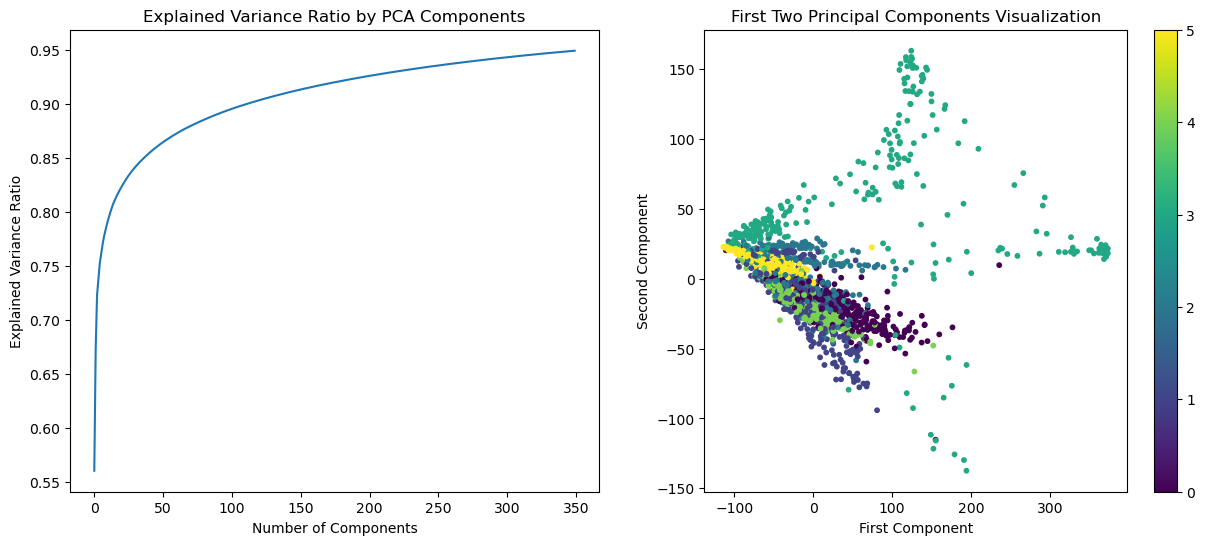

In [8]:
# reshape the data to 2D
X_reshaped = X.reshape(X.shape[0], -1)

# scale by the std and subtract the mean
X_standardized = (X_reshaped - np.mean(X_reshaped, axis=0)) / np.std(X_reshaped, axis=0)

# Initialize PCA to reduce dimensionality to 100 components (as an example)
pca = PCA(n_components=350)
X_pca = pca.fit_transform(X_standardized)

# Print explained variance
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_):.2f}")


# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the explained variance ratio
axes[0].plot(np.cumsum(pca.explained_variance_ratio_))
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance Ratio by PCA Components')

pc_1 = 0
pc_2 = 1
# Visualize the first 2 components
scatter = axes[1].scatter(X_pca[:, pc_1], X_pca[:, pc_2], c=y, cmap='viridis', s=10)
fig.colorbar(scatter, ax=axes[1])
axes[1].set_xlabel('First Component')
axes[1].set_ylabel('Second Component')
axes[1].set_title('First Two Principal Components Visualization')



In [5]:
import numpy as np

# Number of parameters (e.g., weights in the model)
num_params = 6

# Rank of the low-rank matrix
K = 3

# Step 1: Create Sigma_diag, a diagonal covariance matrix
# Randomly initialize the variances for each parameter (variance should be positive)
variances = np.random.rand(num_params)
Sigma_diag = np.diag(variances)

# Step 2: Create Sigma_lowrank, a low-rank covariance matrix
# We'll use K random vectors to form the low-rank part
D = np.random.randn(num_params, K)  # Each column of D is a direction vector

# Compute Sigma_lowrank = D * D^T
Sigma_lowrank = D @ D.T  # This will be a symmetric matrix of rank at most K

# Step 3: Add the two matrices to get Sigma_SWAG
Sigma_SWAG = Sigma_diag + Sigma_lowrank

# Display the results
print("Diagonal covariance matrix (Sigma_diag):")
print(Sigma_diag)
print("\nLow-rank covariance matrix (Sigma_lowrank):")
print(Sigma_lowrank)
print("\nCombined SWAG covariance matrix (Sigma_SWAG):")
print(Sigma_SWAG)


Diagonal covariance matrix (Sigma_diag):
[[0.83971753 0.         0.         0.         0.         0.        ]
 [0.         0.76605651 0.         0.         0.         0.        ]
 [0.         0.         0.73430131 0.         0.         0.        ]
 [0.         0.         0.         0.52343014 0.         0.        ]
 [0.         0.         0.         0.         0.88538567 0.        ]
 [0.         0.         0.         0.         0.         0.24880553]]

Low-rank covariance matrix (Sigma_lowrank):
[[ 0.602612   -0.17784378 -0.18084666 -0.11438523  2.31405834 -0.3466331 ]
 [-0.17784378  2.23706468 -1.65077005 -0.15877428 -0.92711115  1.258161  ]
 [-0.18084666 -1.65077005  1.43412508  0.05796119 -0.6354737  -0.86324358]
 [-0.11438523 -0.15877428  0.05796119  0.35590774 -0.08811578  0.12838001]
 [ 2.31405834 -0.92711115 -0.6354737  -0.08811578  9.25585909 -1.28941381]
 [-0.3466331   1.258161   -0.86324358  0.12838001 -1.28941381  0.89620974]]

Combined SWAG covariance matrix (Sigma_SWAG):
[